In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
import mysql.connector

print("Libraries imported successfully")


Libraries imported successfully


In [2]:
def load_data_from_mysql():

    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='pass1234@',
        database='amazonSales'
    )

    query = """
        SELECT 
            product_name,
            SUBSTRING_INDEX(category, '|', 1) as main_category,
            discounted_price,
            actual_price,
            discount_percentage,
            rating, 
            rating_count
        FROM products
        WHERE discounted_price IS NOT NULL 
            AND rating IS NOT NULL
            AND rating_count IS NOT NULL
    """

    df = pd.read_sql(query, conn)
    conn.close()

    return df

df = load_data_from_mysql()

print(f"Loaded {len(df)} products")
print(f"Data range: {df.shape}")
df.head()
print(df.columns.tolist())

Loaded 1351 products
Data range: (1351, 7)
['product_name', 'main_category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']


/var/folders/8w/9hxx_8m540zcg2yy692kdy480000gn/T/ipykernel_12412/714819023.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
df = load_data_from_mysql()

discounted = df[df['discount_percentage'] > 0]['rating']
non_discounted = df[df['discount_percentage'] == 0]['rating']

print("=" * 60)
print("T-TEST: DISCOUNTED VS NON_DISCOUNTED PRODUCTS")
print("=" * 60)
print(f"\nDiscounted Products: n = {len(discounted)}, mean = {discounted.mean():.3f}")
print(f"Non-discounted Products: n = {len(non_discounted)}, mean = {non_discounted.mean():.3f}")

T-TEST: DISCOUNTED VS NON_DISCOUNTED PRODUCTS

Discounted Products: n = 1304, mean = 4.083
Non-discounted Products: n = 47, mean = 4.238


/var/folders/8w/9hxx_8m540zcg2yy692kdy480000gn/T/ipykernel_12412/714819023.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [8]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(discounted, non_discounted)

print(f"\nT-Statistics: {t_statistic:.4f}")
print(f"P-Value: {p_value:.6f}")


T-Statistics: -3.2973
P-Value: 0.001002


In [9]:
if p_value < 0.001:
    print("HIGHLY SIGNIFICANT difference (p < 0.001)")
elif p_value < 0.05:
    print("SIGNIFICANT difference (p < 0.05)")
else:
    print("NO significant difference (p >= 0.05)")

SIGNIFICANT difference (p < 0.05)


In [10]:
pooled_std = np.sqrt(((len(discounted) - 1) * discounted.std() ** 2 + 
                      (len(non_discounted) - 1) * non_discounted.std() ** 2)/
                      (len(discounted) + len(non_discounted) - 2))

cohens_d = (discounted.mean() - non_discounted.mean()) / pooled_std

print(f"\nEffect Size (Cohen's d): {cohens_d:.3f}")

if abs(cohens_d) < 0.2:
    print("→ Small effect")
elif abs(cohens_d) < 0.5:
    print("→ Medium effect")
else:
    print("→ Large effect")


Effect Size (Cohen's d): -0.490
→ Medium effect


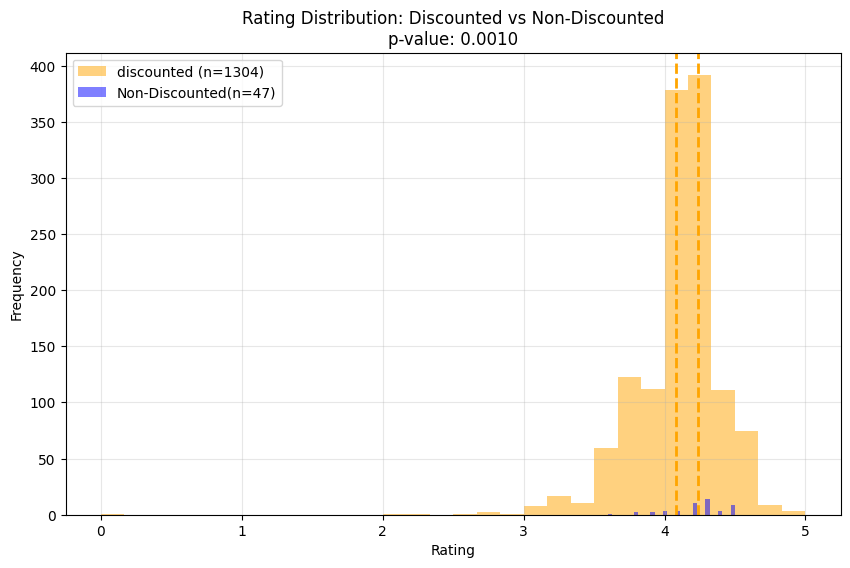

In [11]:
plt.figure(figsize=(10,6))
plt.hist(discounted, bins = 30, alpha=0.5, label=f'discounted (n={len(discounted)})', color='orange')
plt.hist(non_discounted, bins=30, alpha=0.5, label=f'Non-Discounted(n={len(non_discounted)})', color='blue')
plt.xlabel('Rating')
plt.ylabel("Frequency")
plt.title(f'Rating Distribution: Discounted vs Non-Discounted\np-value: {p_value:.4f}')
plt.legend()
plt.axvline(discounted.mean(), color='orange', linestyle='--', linewidth=2)
plt.axvline(non_discounted.mean(), color='orange', linestyle='--', linewidth=2)
plt.grid(True, alpha = 0.3)
plt.savefig('../results/visualizations/screenshots/ttest_discounted.png', dpi=300)
plt.show()

In [ ]:
df['price_tier'] = pd.cut(df['discounted_price'],
                        bins = [0, 10, 50, 150, 500, df['discounted_price'].max()],
                        labels = ['Budget', 'Economy', 'Mid-Range', 'Premium', 'Luxury'])

budget = df[df['price_tier'] == 'Budget']['rating'].dropna()
economy = df[df['price_tier'] == 'Economy']['rating'].dropna()
mid_range = df[df['price_tier'] == 'Mid-Range']['rating'].dropna()
premium = df[df['price_tier'] == 'Premium']['rating'].dropna()
luxury = df[df['price_tier'] == 'Luxury']['rating'].dropna()

print("=" * 60)
print("RATING ACROSS PRICE TIERS")
print("=" * 60)

tier_stats = df.groupby('price_tier')['rating'].agg(['count', 'mean', 'std'])
print("\nGroup Statistics:")
print(tier_stats)



RATING ACROSS PRICE TIERS

Group Statistics:
            count      mean       std
price_tier                           
Budget        661  4.075794  0.320115
Economy       472  4.068008  0.350392
Mid-Range     113  4.153097  0.239445
Premium        95  4.184211  0.140906
Luxury         10  4.300000  0.163299


/var/folders/8w/9hxx_8m540zcg2yy692kdy480000gn/T/ipykernel_12412/2682983161.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = df.groupby('price_tier')['rating'].agg(['count', 'mean', 'std'])


In [15]:
from scipy.stats import f_oneway

f_statistic, p_value = f_oneway(budget, economy, mid_range, premium, luxury)

print(f"\nF-Statistic: {f_statistic:.4f}")
print(f"P-Value: {p_value:.6f}")

if p_value < 0.001:
    print("\nHIGHLY SIGNIFICANT differences between tiers (p < 0.001)")
    print(" At least one tier differs significantly from others")

elif p_value < 0.05:
    print("\nSIGNIFICANT differences between tiers (p < 0.05)")

else: 
    print("\n NO significant differences between tiers (p >= 0.05)")


F-Statistic: 5.2586
P-Value: 0.000333

HIGHLY SIGNIFICANT differences between tiers (p < 0.001)
 At least one tier differs significantly from others


<Figure size 1200x600 with 0 Axes>

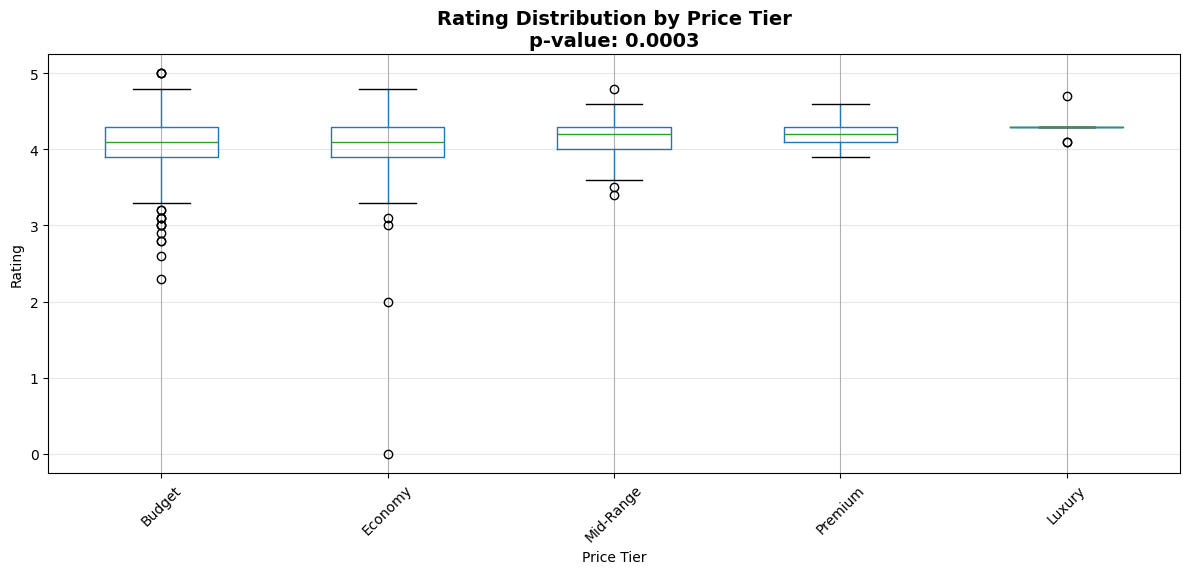

In [17]:
plt.figure(figsize=(12, 6))
df.boxplot(column='rating', by='price_tier', figsize=(12, 6))
plt.suptitle('')
plt.title(f'Rating Distribution by Price Tier\np-value: {p_value:.4f}',
            fontsize = 14, fontweight='bold')
plt.xlabel('Price Tier')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/visualizations/screenshots/price_tiers.png', dpi=300)
plt.show()

In [ ]:
if p_value < 0.05:
    print("\n" + "="*60)
    print("POST-HOC ANALYSIS: Pairwise Comparisons")
    print("="*60)

    from scipy.stats import ttest_ind
    from itertools import combinations
    
    tiers = [('Budget', budget), ('Economy', economy), ('Mid-Range', mid_range), 
             ('Premium', premium), ('Luxury', luxury)]
    
    for (name1, group1), (name2, group2) in combinations(tiers, 2):
        t_stat, p_val = ttest_ind(group1, group2)
        if p_val < 0.05:
            print(f"{name1} vs {name2}: p = {p_val:.4f} ✓ Significant")


POST-HOC ANALYSIS: Pairwise Comparisons
Budget vs Mid-Range: p=0.0144 ✓ Significant
Budget vs Premium: p=0.0012 ✓ Significant
Budget vs Luxury: p=0.0275 ✓ Significant
Economy vs Mid-Range: p=0.0147 ✓ Significant
Economy vs Premium: p=0.0016 ✓ Significant
Economy vs Luxury: p=0.0374 ✓ Significant
Premium vs Luxury: p=0.0166 ✓ Significant


In [19]:

df['rating_category'] = pd.cut(df['rating'], 
                               bins=[0, 3.5, 4.0, 4.5, 5.0],
                               labels=['Low (≤3.5)', 'Average (3.6–4.0)', 
                                       'Good (4.1–4.5)', 'Excellent (4.6–5.0)'])

print("\n" + "="*60)
print("RATING CATEGORY DISTRIBUTION")
print("="*60)
print(df['rating_category'].value_counts())


RATING CATEGORY DISTRIBUTION
rating_category
Good (4.1–4.5)         823
Average (3.6–4.0)      432
Low (≤3.5)              67
Excellent (4.6–5.0)     28
Name: count, dtype: int64


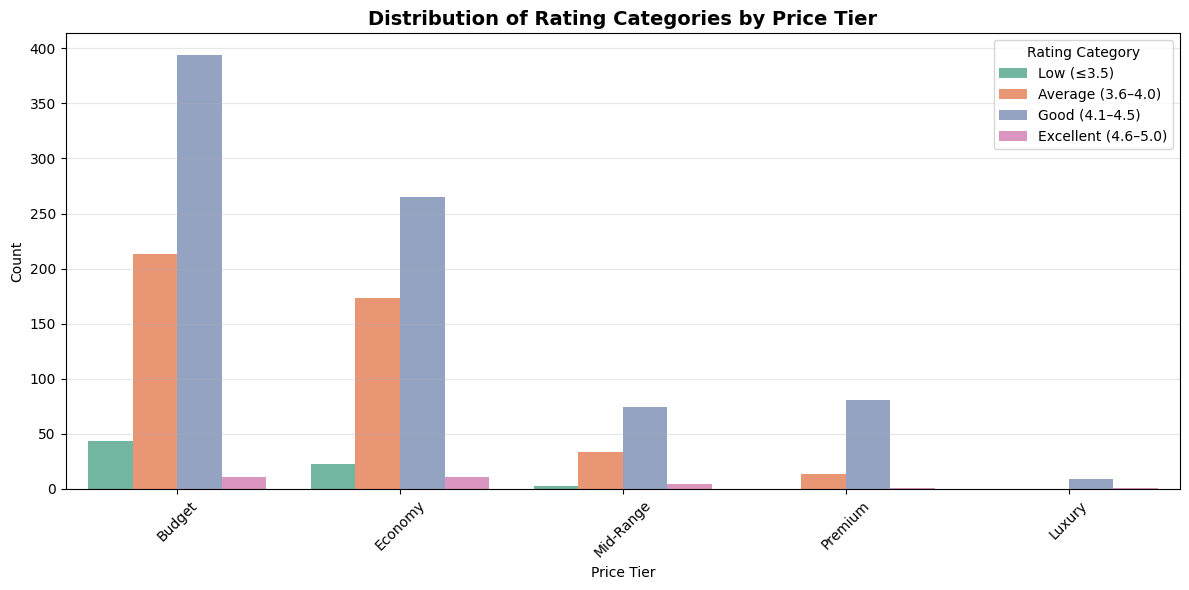

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='price_tier', hue='rating_category', palette='Set2')
plt.title('Distribution of Rating Categories by Price Tier', fontsize=14, fontweight='bold')
plt.xlabel('Price Tier')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/visualizations/screenshots/rating_category_tiers.png', dpi=300)
plt.show()

In [21]:
print("\n" + "="*60)
print("CORRELATION ANALYSIS: PRICE vs RATING")
print("="*60)
corr, p_corr = stats.pearsonr(df['discounted_price'], df['rating'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_corr:.6f}")

if p_corr < 0.05:
    print("→ Significant correlation between price and rating.")
else:
    print("→ No significant correlation between price and rating.")



CORRELATION ANALYSIS: PRICE vs RATING
Pearson Correlation Coefficient: 0.1199
P-Value: 0.000010
→ Significant correlation between price and rating.


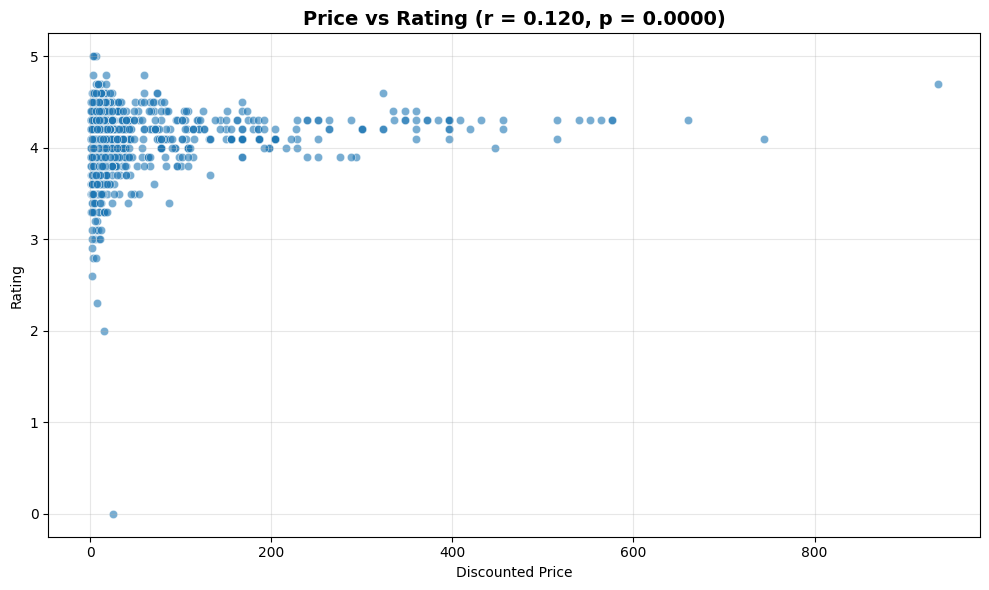


Analysis Completed Successfully


In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='discounted_price', y='rating', alpha=0.6)
plt.title(f'Price vs Rating (r = {corr:.3f}, p = {p_corr:.4f})', fontsize=14, fontweight='bold')
plt.xlabel('Discounted Price')
plt.ylabel('Rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/visualizations/screenshots/price_vs_rating.png', dpi=300)
plt.show()

print("\nAnalysis Completed Successfully")